# Book recommendations: 
### An exporation of Collaberative and Content Based Filtering

- EDA 
- Collaberative based filtering
- Content based filtering 

In [1]:
import pandas as pd
import numpy as np

In [846]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import cm
import networkx as nx

In [542]:
import surprise as sur

In [547]:
import random

In [5]:
from collections import defaultdict

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Importing data 

In [967]:
ratings = pd.read_csv( 'goodbooks-10k/ratings.csv')
books = pd.read_csv( 'goodbooks-10k/books.csv' )
book_tags = pd.read_csv('goodbooks-10k/book_tags.csv')
tags = pd.read_csv('goodbooks-10k/tags.csv')

In [968]:
ratings_full = pd.read_csv( 'goodbooks-10k/ratings.csv')
books_full = pd.read_csv( 'goodbooks-10k/books.csv' )

# EDA

**Books dataframe contains the meta data (additional features)**

In [969]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [970]:
books.shape

(10000, 23)

**Top 10 rated books**

In [971]:
books.groupby('original_title')[['average_rating']].mean().sort_values(by='average_rating', ascending=False).head()

,average_rating
original_title,
The Complete Calvin and Hobbes,4.82
Words of Radiance,4.77
Mark of the Lion Trilogy,4.76
It's a Magical World: A Calvin and Hobbes Collection,4.75
Complete Harry Potter Boxed Set,4.74


**Top 10 popular books**

In [972]:
books.groupby('original_title')[['work_ratings_count']].mean().sort_values(by='work_ratings_count', ascending=False).head()

,work_ratings_count
original_title,
The Hunger Games,4942365.0
Harry Potter and the Philosopher's Stone,4800065.0
To Kill a Mockingbird,3340896.0
The Great Gatsby,2773745.0
The Fault in Our Stars,2478609.0


**Merge tag names dataframe with tag id dataframe**

In [973]:
tags_join_DF = pd.merge(book_tags, tags, on='tag_id', how='inner')
tags_join_DF.tail()

,goodreads_book_id,tag_id,count,tag_name
999907,31538635,14690,6,hogwarts
999908,32848471,16149,21,jan-2017
999909,33288638,27821,9,single-mom
999910,33288638,11478,7,fave-author
999911,33288638,27939,7,slowburn


**Rating dataframe** are sorted by book_id and user_id.

In [974]:
ratings = ratings[['user_id', 'book_id', 'rating']]
ratings.head()

,user_id,book_id,rating
0,314,1,5
1,439,1,3
2,588,1,5
3,1169,1,4
4,1185,1,4


In [975]:
n_users = int(ratings.user_id.nunique())
n_books = int(ratings.book_id.nunique())
print("n_users = ",n_users, "||", "n_books = ", n_books, "||", "max_n_ratings = ", n_users*n_books)

n_users =  53424 || n_books =  10000 || max_n_ratings =  534240000


With only 981756 number of ratings (out of the possible 534240000 user-item combinations), the matrix is very sparse, with less than 0.001 percent as ratings. 

In [983]:
print('There are {} duplictates found in {} rows'.format(ratings.duplicated().sum(), ratings.shape[0]))

There are 1644 duplictates found in 981756 rows


Remove duplicates where a user has rated the same book more than once

In [984]:
ratings.drop_duplicates(inplace=True)

**Distribution of ratings:**
4 is the most popular rating, with relatively few 1s and 2s. People tend to give more positive ratings.

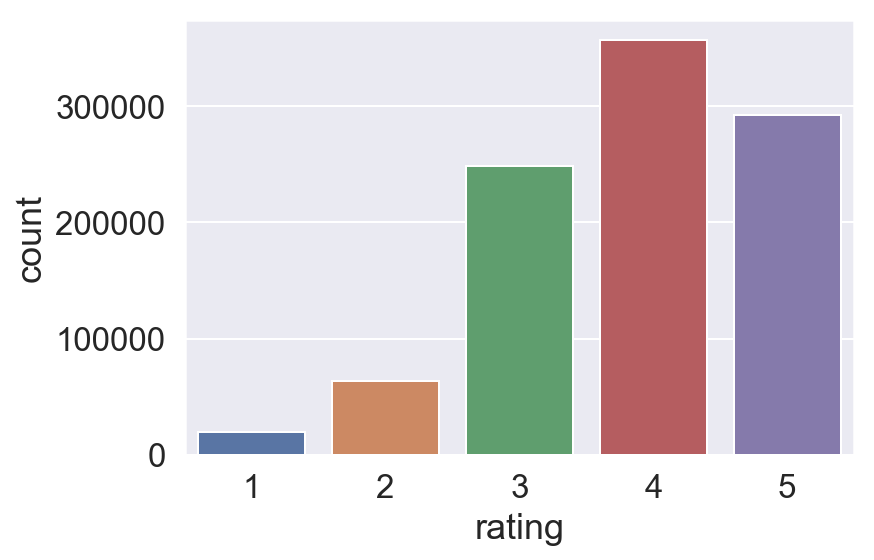

In [985]:
sns.countplot(data=ratings, x=ratings.rating);

**User Reviews**
- Most users rate 18 books
- As little as 1 review per user and at most 200.

In [986]:
user_reviews = ratings.groupby('user_id')[['rating']].count().sort_values(by='rating', ascending=False)
user_reviews.describe()

,rating
count,53424.000000
mean,18.345912
std,26.237043
min,1.000000
25%,3.000000
50%,8.000000
75%,22.000000
max,200.000000


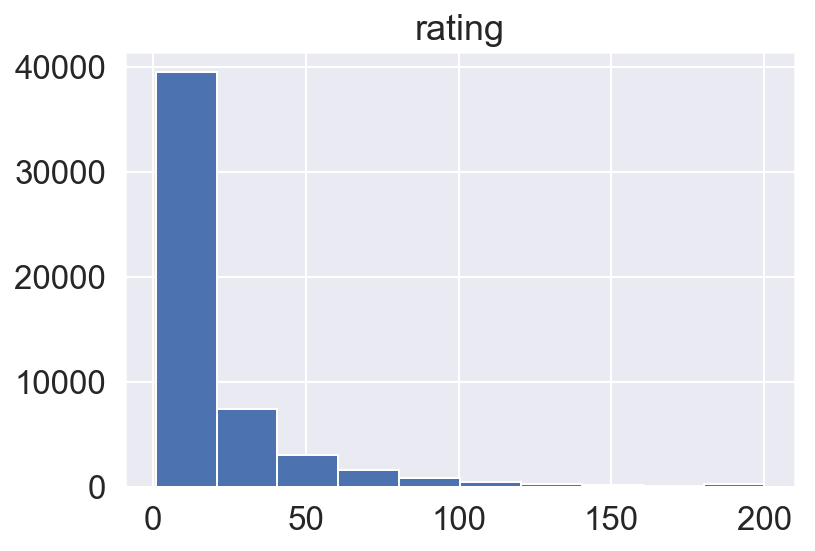

In [987]:
user_reviews.hist();

To cope with the computing power, I will reduce the dataset size. I will only include users that have rated minimum 80 reviews.

In [988]:
print('{} users who rated less than 80 book reviews'.format((user_reviews<80).sum().sum()))

51362 users who rated less than 80 book reviews


In [989]:
user_more80 = user_reviews[user_reviews['rating']>=80].reset_index()
ratings_80 = ratings[ratings.user_id.isin(user_more80.user_id)]

In [990]:
ratings_80.shape

(242147, 3)

**Book Reviews**
- Most books have 25 reviews 
- As little as 1 review per book and at most 100.

In [991]:
book_reviews = ratings_80.groupby('book_id')[['rating']].count().sort_values(by='rating')
book_reviews.describe()

,rating
count,9675.000000
mean,25.028114
std,26.473215
min,1.000000
25%,6.000000
50%,14.000000
75%,33.000000
max,100.000000


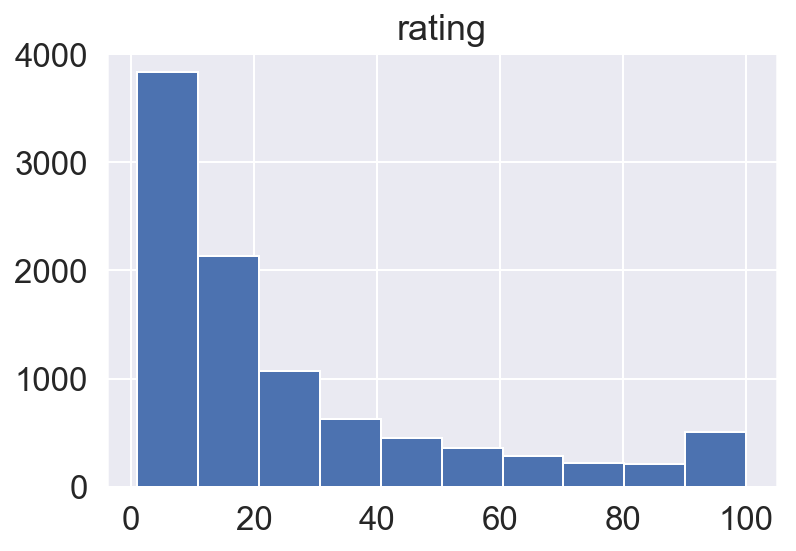

In [992]:
book_reviews.hist();

To cope with the computing power, I will reduce the dataset size further. I will only include books that have minimum 30 reviews. 

In [993]:
print('{} books that have been rated less than 30 times'.format((book_reviews<30).sum().sum()))

6944 books that have been rated less than 30 times


In [994]:
book_more30 = book_reviews[book_reviews['rating']>=30].reset_index()
ratings = ratings_80[ratings_80.user_id.isin(book_more30.book_id)]

**Distribution of mean users** suggests no notorious downvoters and to rate above a 4 is less likely. 

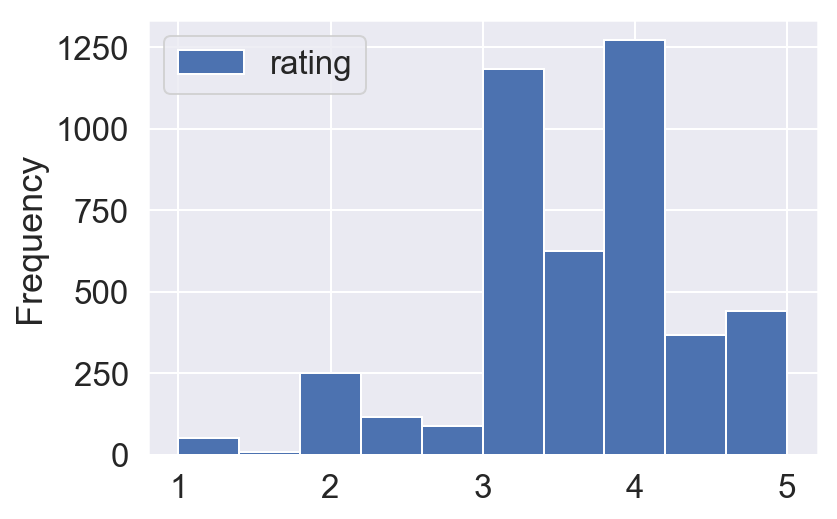

In [995]:
ratings.groupby('book_id')[['rating']].mean().sort_values(by='rating', ascending=False).plot(kind='hist', bins=10);

In [998]:
ratings.shape

(11215, 3)

Creating the utility matrix to visualise the sparsity. The NaNs imply that the user has not rated the corresponding book. 

In [997]:
index=sorted(list(ratings['user_id'].unique()))
columns=sorted(list(ratings['book_id'].unique()))
util_df=pd.pivot_table(data=ratings[:100000],values='rating',index='user_id',columns='book_id')
util_df.head()

book_id,1,2,3,4,5,6,7,8,9,11,...,9946,9964,9966,9974,9977,9984,9990,9994,9995,9996
user_id,,,,,,,,,,,,,,,,,,,,,
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
173,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Modelling

## Collaberative filtering 

**I am going to start with collaberative filtering which focuses on finding users who have given similar ratings to the same books.**

* Provides strong predictive power and recquires very little information


* Underlying tastes of books expressed by latent features are not interpretable because there is no content-related properties of metadata. 
* Cold-start issue; when a new book is added, until it has been rated by a substantial number of users, the model is not able to make any personalized reccomendations. 
* The long tail issue: The more popular books are weighted more heavily and tend to be reccomended more. 

The reader function serves to specify which columns are referring to user, items and ratings.

In [1002]:
reader = sur.Reader(rating_scale=(1, 5))

In [1003]:
data = sur.Dataset.load_from_df(
    ratings[['user_id', 'book_id', 'rating']], reader)

**Two different approaches to collab filtering**


**Model based approaches:** SVD and NMF
- Easy creation and explanation of results 
- Performance reduces when data is sparse (data is non scalable) 
- This deals with sparse/missing data well due to dimensionality reduction
- Inference is intractable due to hidden/latent features. 

**Memory based approaches**: KNN and slope one model
- Easy creation and explanation of results 
- Performance reduces when data is sparse (data is non scalable) 

In [623]:
#setting random seed so algo comes out with consistent results 
my_seed = 1
random.seed(my_seed)
np.random.seed(my_seed)

In [1026]:
np.random.seed(my_seed)

benchmark = []
for algorithm in [sur.SVD(),sur.NMF(), sur.SlopeOne(), sur.KNNWithMeans()]:
    results = sur.model_selection.cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [1027]:
pd.DataFrame(benchmark)

,test_rmse,fit_time,test_time,Algorithm
0,0.896374,0.728737,0.052681,SVD
1,1.092833,0.987735,0.030802,NMF
2,1.049570,0.538278,0.194376,SlopeOne
3,1.011268,0.008387,0.047855,KNNWithMeans


**Plot comparisions of RMSE in different model approaches**

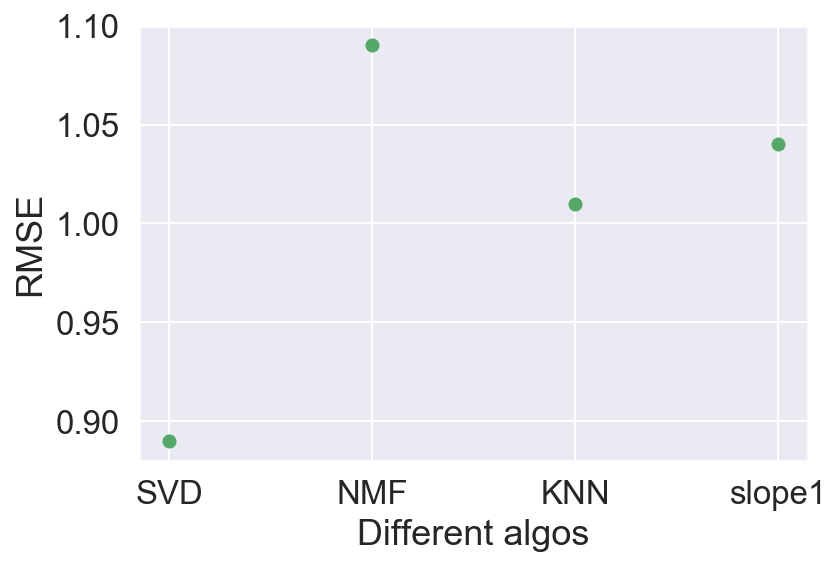

In [1028]:
mses = [.89, 1.09, 1.01, 1.04]
algos = ['SVD', "NMF",  'KNN','slope1']
plt.plot(algos, mses, 'go',  )
plt.xlabel("Different algos")
plt.ylabel("RMSE")
plt.show()

SVD performs the best as it has the smallest RMSE value - I will tune the hyperparemeters of SVD. 

In [1029]:
raw_ratings = data.raw_ratings
np.random.seed(1)
random.shuffle(raw_ratings)

threshold = int(.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings

Select the best algo with a grid search

In [1035]:
np.random.seed(my_seed)

print('Grid Search...')
param_grid = {'n_factors': [20, 25, 30], 
              'reg_all': [0.08, 0.1, 0.13, 0.15],
                'n_epochs': [5, 10,15], 
                 'lr_all': [0.005, 0.01]}
grid_search = sur.model_selection.GridSearchCV(sur.SVD,
                                               param_grid,
                                               measures=['rmse'],
                                               cv=3,
                                               refit=True)
grid_search.fit(data)
print(grid_search.best_params['rmse'])

algo = grid_search.best_estimator['rmse']

trainset = data.build_full_trainset()
algo.fit(trainset)

trainset_build = trainset.build_testset()
predictions_train = algo.test(trainset_build)
print('Training score ', end='   ')
sur.accuracy.rmse(predictions_train)

testset = data.construct_testset(B_raw_ratings)  
predictions_test_best = algo.test(testset)
print('Test score (rated items) ', end=' ')
sur.accuracy.rmse(predictions_test_best)

no_ratings = trainset.build_anti_testset()
predictions_no_ratings = algo.test(no_ratings)
print('Test score (unrated items) ', end='   ')
sur.accuracy.rmse(predictions_no_ratings, verbose=False)

Grid Search...
{'n_factors': 25, 'reg_all': 0.08, 'n_epochs': 15, 'lr_all': 0.01}
Training score    RMSE: 0.7336
Test score (rated items)  RMSE: 0.8932
Test score (unrated items)    

0.4115558430183793

**Output: optimised RMSE score is 0.8932**

I will use these SVD predictions to return the top 10 rated books per user

In [1036]:
def get_recommendations(predictions, topN, user):
    top_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_recs[uid].append((iid, est))
     
    for uid, user_ratings in top_recs.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_recs[uid] = user_ratings[:topN]  
    
    top_n_list = []
    for key in top_recs.keys():
        for val in top_recs[key]:
            top_n_list.append([key, val[0], val[1]])

    df_top = pd.DataFrame(top_n_list, columns=['users', 'id', 'est'])
    
    df_top = pd.merge(df_top, books[['id', 'original_title', 'authors']], on='id', how='left')
    df_top.dropna(inplace=True)
    subset_user = df_top[df_top['users'] == user]
    return subset_user

In [1037]:
get_recommendations(predictions_test_best, 10, 2066)

,users,id,est,original_title,authors
354,2066,165,3.658330,A Feast for Crows,George R.R. Martin
355,2066,2449,3.459412,The Imperfectionists,Tom Rachman
356,2066,880,3.410885,The Summoning,Kelley Armstrong
357,2066,7617,3.360444,Dragon's Oath,"P.C. Cast, Kristin Cast"
358,2066,981,3.360444,Blue Bloods,Melissa de la Cruz
359,2066,2593,3.360444,Stargazer,Claudia Gray
360,2066,518,3.284410,Peter Pan,"J.M. Barrie, Michael Hague"
361,2066,187,3.268961,Uglies,Scott Westerfeld
362,2066,134,3.183707,City of Glass,Cassandra Clare
363,2066,833,2.870941,The Chamber,John Grisham


**These books are all fiction books, typically with an overriding theme of fantasy. They have been adapted into either a Television Series or Film**

In [1038]:
get_recommendations(predictions_test_best, 10, 368)

,users,id,est,original_title,authors
750,368,1275,3.460285,An Echo in the Bone,Diana Gabaldon
751,368,758,3.435194,Stiff: The Curious Lives of Human Cadavers,Mary Roach
752,368,2632,3.422112,The Sparrow,Mary Doria Russell
753,368,312,3.310958,The Graveyard Book,"Neil Gaiman, Dave McKean"
754,368,1704,3.266216,Mother Night,Kurt Vonnegut Jr.
755,368,1231,3.220327,Loving Frank,Nancy Horan
756,368,405,3.215975,Breakfast of Champions,Kurt Vonnegut Jr.
757,368,638,3.175420,A Visit From the Goon Squad,Jennifer Egan
758,368,1441,3.174210,My Life in France,"Julia Child, Alex Prud'Homme"
759,368,687,3.174210,1776,David McCullough


**Overall, these books are novels, set with some degrees of realism, exploring historical and psycholgical fiction.** 

## Content filtering

Many ways to peform content based filtering: determine how similar a pair of items are based on their metadata tags.

- NLP techniques; analysing the descriptions of movies using TF-IDF or topic modeling to define a measure of similarity (using cosine or jaccard similarity) 
- Machine learning; classification models

First, I will focus on using NLP techniques

In [1039]:
books_with_tags = pd.merge(books, tags_join_DF, left_on='book_id', right_on='goodreads_book_id', how='inner')

In [1040]:
temp_df = books_with_tags.groupby('book_id')['tag_name'].apply(' '.join).reset_index()

In [1041]:
books= pd.merge(books, temp_df, left_on='book_id', right_on='book_id', how='inner')

Recommend books using the cosine similarity scores of a corpus containing book authors and book tags.

In [1042]:
books['corpus'] = (pd.Series(books[['authors', 'tag_name']]
                .fillna('')
                .values.tolist()
                ).str.join(' '))

In [1043]:
tf_corpus = TfidfVectorizer(ngram_range=(1, 3),min_df=0, stop_words='english')
tfidf_matrix_corpus = tf_corpus.fit_transform(books['corpus'])
cosine_sim_corpus = linear_kernel(tfidf_matrix_corpus, tfidf_matrix_corpus)

Recommend the 20 most similar books

In [1044]:
titles = books['title']
indices = pd.Series(books.index, index=books['title'])
authors = books['authors']

def corpus_recommendations(title, num_recs):
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_corpus[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recs]
    book_indices = [i[0] for i in sim_scores]
    
    return list(zip(titles.iloc[book_indices], authors.iloc[book_indices]))

In [1045]:
corpus_recommendations("The Hobbit", 21)

[('The Lord of the Rings (The Lord of the Rings, #1-3)', 'J.R.R. Tolkien'),
 ('The Two Towers (The Lord of the Rings, #2)', 'J.R.R. Tolkien'),
 ('The Return of the King (The Lord of the Rings, #3)', 'J.R.R. Tolkien'),
 ('The Fellowship of the Ring (The Lord of the Rings, #1)', 'J.R.R. Tolkien'),
 ('The Silmarillion (Middle-Earth Universe)',
  'J.R.R. Tolkien, Christopher Tolkien, Ted Nasmith'),
 ('Unfinished Tales of Númenor and Middle-Earth',
  'J.R.R. Tolkien, Christopher Tolkien'),
 ('The Children of Húrin', 'J.R.R. Tolkien, Christopher Tolkien, Alan Lee'),
 ('J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings',
  'J.R.R. Tolkien'),
 ('The Hobbit: Graphic Novel',
  'Chuck Dixon, J.R.R. Tolkien, David Wenzel, Sean Deming'),
 ('The Once and Future King (The Once and Future King #1-4)', 'T.H. White'),
 ('The Subtle Knife (His Dark Materials, #2)', 'Philip Pullman'),
 ('The Golden Compass (His Dark Materials, #1)', 'Philip Pullman'),
 ('The Amber Spyglass (His Dark Ma

**Two simple intuitive stratagies to improve the value of reccomendations:**

- **Anti-flood**: penalise the second and third recomendations if they had the same similarity scores to the top reccomendation
- **Dithering**: Add a wild card reccomendation to keep it interesting and allow users to keep being exposed to new content. 

Now, I would like to filter out the books that have been written by the same author, exposing users to new content. 

In [1046]:
titles = books['title']
indices = pd.Series(books.index, index=books['title'])
authors = books['authors']

def corpus_noauthors(title, num_recs):
    
    idx = indices[title]
    author_idx = authors[idx]
    sim_scores = list(enumerate(cosine_sim_corpus[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    book_indices = [i[0] for i in sim_scores]
 
    temp_authors = []
    for a in authors.iloc[book_indices]:
        if str(author_idx.split(',')[0]) not in a:
            temp_authors.append(a)
        else:
            temp_authors.append(np.nan) 
    new_auth_i = pd.Series(temp_authors, index=book_indices)
    new_auth_i.dropna(inplace=True)
    
    new_indices = [i for i in new_auth_i.index]
    new_indices = new_indices[1:num_recs]

    
    return list(zip(titles.iloc[new_indices], authors.iloc[new_indices]))


In [1047]:
corpus_noauthors("The Hobbit", 21)

[('The Subtle Knife (His Dark Materials, #2)', 'Philip Pullman'),
 ('The Golden Compass (His Dark Materials, #1)', 'Philip Pullman'),
 ('The Amber Spyglass (His Dark Materials, #3)', 'Philip Pullman'),
 ('The Last Unicorn (The Last Unicorn, #1)', 'Peter S. Beagle'),
 ("The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)",
  'Douglas Adams'),
 ('His Dark Materials (His Dark Materials #1-3)', 'Philip Pullman'),
 ("The Magician's Nephew (Chronicles of Narnia, #6)", 'C.S. Lewis'),
 ('The Lion, the Witch, and the Wardrobe (Chronicles of Narnia, #1)',
  'C.S. Lewis'),
 ('A Wizard of Earthsea (Earthsea Cycle, #1)', 'Ursula K. Le Guin'),
 ('A Clash of Kings  (A Song of Ice and Fire, #2)', 'George R.R. Martin'),
 ('The Last Battle (Chronicles of Narnia, #7)', 'C.S. Lewis'),
 ('A Wrinkle in Time (A Wrinkle in Time Quintet, #1)', "Madeleine L'Engle"),
 ('The Voyage of the Dawn Treader (Chronicles of Narnia, #3)',
  'C.S. Lewis, Pauline Baynes'),
 ('The Fires of Heaven (Whe

In [1048]:
corpus_noauthors("Romeo and Juliet", 21)

[('Great Expectations', 'Charles Dickens'),
 ('The Catcher in the Rye', 'J.D. Salinger'),
 ('Death of a Salesman', 'Arthur Miller'),
 ('Lord of the Flies', 'William Golding'),
 ('Of Mice and Men', 'John Steinbeck'),
 ('A Streetcar Named Desire', 'Tennessee Williams'),
 ('Beowulf', 'Unknown, Seamus Heaney'),
 ('Ethan Frome', 'Edith Wharton'),
 ('Frankenstein',
  'Mary Wollstonecraft Shelley, Percy Bysshe Shelley, Maurice Hindle'),
 ('The Canterbury Tales', 'Geoffrey Chaucer, Nevill Coghill'),
 ('A Separate Peace', 'John Knowles'),
 ('Heart of Darkness', 'Joseph Conrad'),
 ('The Great Gatsby', 'F. Scott Fitzgerald'),
 ('Pygmalion', 'George Bernard Shaw'),
 ('The Awakening', 'Kate Chopin'),
 ('Pride and Prejudice', 'Jane Austen'),
 ('The Adventures of Huckleberry Finn',
  'Mark Twain, John Seelye, Guy Cardwell'),
 ('A Tale of Two Cities',
  'Charles Dickens, Richard Maxwell, Hablot Knight Browne'),
 ('The Importance of Being Earnest', 'Oscar Wilde'),
 ('The Glass Menagerie', 'Tennessee Wi

Create a reccommendation network

In [1049]:
def prepare_df(title, num_recs):
    
    idx = indices[title]
    author_idx = authors[idx]
    sim_scores = list(enumerate(cosine_sim_corpus[idx]))
    
    sim = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    book_indices = [i[0] for i in sim]
 
    temp_authors = []
    for a in authors.iloc[book_indices]:
        if str(author_idx.split(',')[0]) not in a:
            temp_authors.append(a)
        else:
            temp_authors.append(np.nan) 
    new_auth_i = pd.Series(temp_authors, index=book_indices)
    new_auth_i.dropna(inplace=True)
    
    new_indices = [i for i in new_auth_i.index]
    new_indices = new_indices[1:num_recs]
    
    score_indices = [i[1] for i in sim_scores]
    new_scores = pd.Series(score_indices, index=book_indices)
    
    final_df = pd.DataFrame((zip(titles.iloc[new_indices], 
                                 new_scores.iloc[new_indices])))
    final_df['original_title'] = final_df.apply(lambda x: title, axis=1)
    
    return final_df

In [1165]:
def inspire_me(title, number_of_recs):

    df = prepare_df(title, number_of_recs)  
    #log to exaggarate differences between predictions 
    df['log'] = (np.log(1 + df[1]))
    
    G = nx.from_pandas_edgelist(df, 'original_title', 0, 'log')
    
    plt.figure(figsize=(6,6))
    
    pos = nx.spring_layout(G)

    return nx.draw(G, node_size=0, font_size=12,pos=pos, seed=1, with_labels=True)

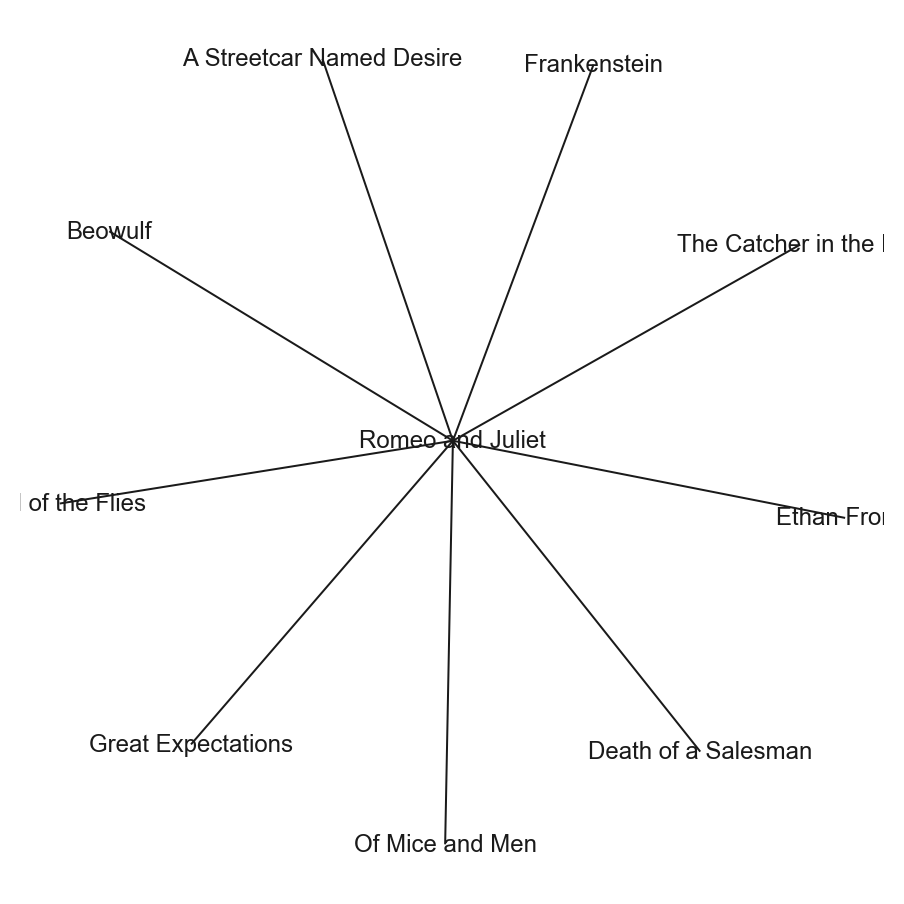

In [1169]:
inspire_me("Romeo and Juliet", 10)

## Future directions

- SVD++ to optimise collab filtering score further 
- FuzzyWuzzy package to build the function that remove books of the same series or author.